In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import random
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
import warnings
warnings.filterwarnings("ignore") 

plt.rcParams['font.size'] = 10

In [4]:
tf.test.gpu_device_name()

''

#### Load Dataset

In [20]:
train_dir = r"C:\Users\aadit\Documents\IML\Grp Project\IML Bird Dataset\Birds_25\train"
#val_dir = '/kaggle/input/indian-birds/Birds_25/valid'

# Get class names from directory names
class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)

Class names: ['Asian-Green-Bee-Eater', 'Brown-Headed-Barbet', 'Cattle-Egret', 'Common-Kingfisher', 'Common-Myna', 'Common-Rosefinch', 'Common-Tailorbird', 'Coppersmith-Barbet', 'Forest-Wagtail', 'Gray-Wagtail', 'Hoopoe', 'House-Crow', 'Indian-Grey-Hornbill', 'Indian-Peacock', 'Indian-Pitta', 'Indian-Roller', 'Jungle-Babbler', 'Northern-Lapwing', 'Red-Wattled-Lapwing', 'Ruddy-Shelduck', 'Rufous-Treepie', 'Sarus-Crane', 'White-Breasted-Kingfisher', 'White-Breasted-Waterhen', 'White-Wagtail']


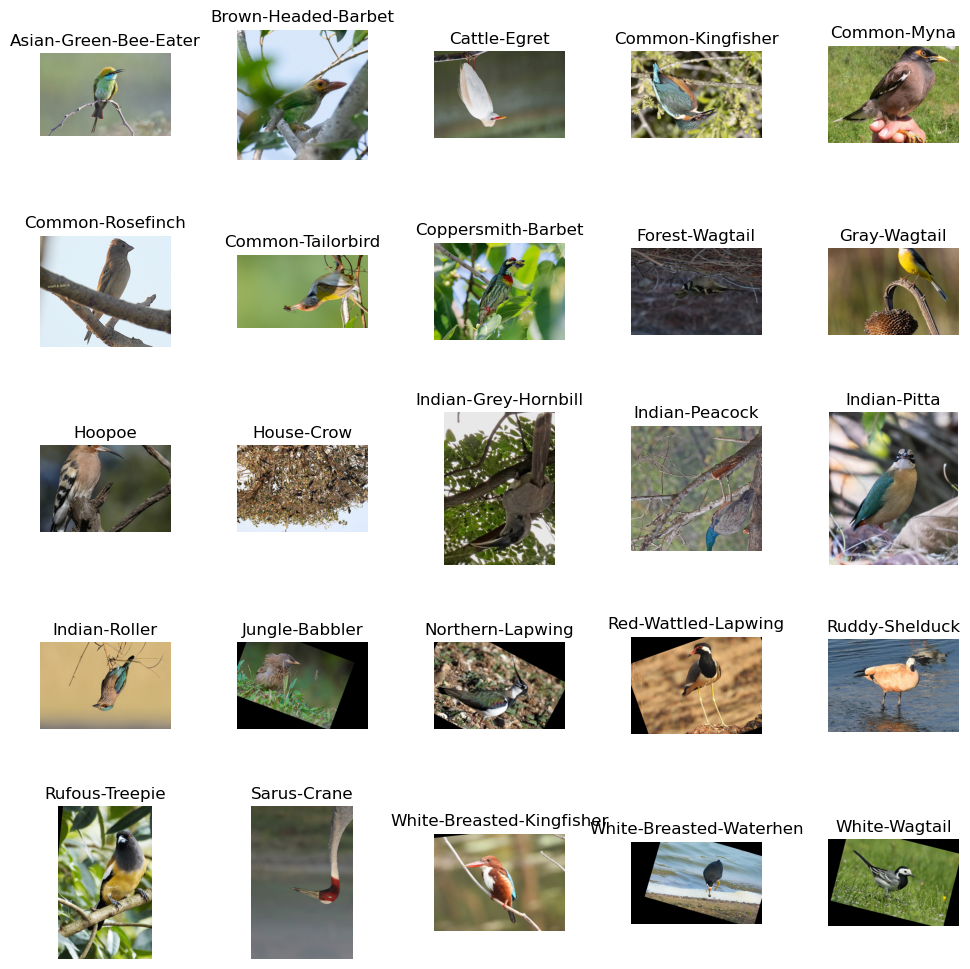

In [21]:
# Create a figure with subplots for each class
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
fig.tight_layout()

# Load and display a random image from each class
for i, cls in enumerate(class_names):
    ax = axs[i // 5][i % 5]
    img_path = os.path.join(train_dir, cls, os.listdir(os.path.join(train_dir, cls))[np.random.randint(0, len(os.listdir(os.path.join(train_dir, cls))))])
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(cls)
    
plt.show()

In [44]:
# Define the data generators
with tf.device('/device:GPU:0'):
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       shear_range=0.2, 
                                       zoom_range=0.2, 
                                       horizontal_flip=True)
    
    valid_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_directory(r"C:\Users\aadit\Documents\IML\Grp Project\IML Bird Dataset\Birds_25\train", 
                                                        target_size=(224, 224), 
                                                        batch_size=32, 
                                                        class_mode='categorical')
    valid_generator = valid_datagen.flow_from_directory(r"C:\Users\aadit\Documents\IML\Grp Project\IML Bird Dataset\Birds_25\valid", 
                                                        target_size=(224, 224), 
                                                        batch_size=32, 
                                                        class_mode='categorical')

Found 30000 images belonging to 25 classes.
Found 7500 images belonging to 25 classes.


with tf.device('/device:GPU:0'):
    # Load the ResNet50 model
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

with tf.device('/device:GPU:0'):
    # Freeze the layers in the base model
    for layer in base_model.layers:
        layer.trainable = False

with tf.device('/device:GPU:0'):
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(512)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.1)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    predictions = tf.keras.layers.Dense(25, activation='softmax')(x)

    # Define the new model
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

with tf.device('/device:GPU:0'):
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    

Model Training

with tf.device('/device:GPU:0'):
    # Define early stopping and model checkpoint callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max', restore_best_weights=True)
    
    # Update the file path to use .keras instead of .h5
    model_checkpoint = ModelCheckpoint(filepath='best_weights.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
    
    # Train the model
    history = model.fit(train_generator, epochs=2, validation_data=valid_generator, callbacks=[early_stopping, model_checkpoint])


#Visualizing The Loss & Accuracy Curves
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [51]:
model = Sequential([
    # Convolutional layers
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the output before passing to Dense layers
    Flatten(),

    # Fully connected layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(25, activation='softmax')  # 25 classes for 25 bird types
])


In [52]:
model.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [ ]:

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='bird_model.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(
    train_generator,
    epochs=2,
    validation_data=valid_generator,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/2
537/938 ━━━━━━━━━━━━━━━━━━━━ 7:54:07 71s/step - accuracy: 0.6625 - loss: 1.0612

In [75]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=5,
    callbacks=[early_stopping]
)


Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1906s 2s/step - accuracy: 0.5120 - loss: 1.5520 - val_accuracy: 0.6120 - val_loss: 1.2907
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1480s 2s/step - accuracy: 0.5459 - loss: 1.4493 - val_accuracy: 0.6593 - val_loss: 1.1599
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1323s 1s/step - accuracy: 0.5736 - loss: 1.3560 - val_accuracy: 0.6708 - val_loss: 1.1119
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 1501s 2s/step - accuracy: 0.6002 - loss: 1.2733 - val_accuracy: 0.6999 - val_loss: 1.0379
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 32740s 35s/step - accuracy: 0.6195 - loss: 1.2086 - val_accuracy: 0.7167 - val_loss: 0.9502


In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [62]:
# Save the model in the recommended Keras format
model.save('sample_model_1.keras')


In [119]:
import random
import numpy as np

# Number of samples per class
samples_per_class = 10

# Initialize storage for sampled images and labels
random_samples = []
random_labels = []

# Dictionary to track sampled images for each class
sampled_per_class = {class_label: 0 for class_label in range(len(valid_generator.class_indices))}

# Loop over the data generator
for images, labels in valid_generator:
    # Break if we have enough samples for all classes
    if all(count >= samples_per_class for count in sampled_per_class.values()):
        break

    # Iterate through the batch
    for i in range(len(labels)):
        class_label = np.argmax(labels[i])  # Get the class index from one-hot encoding

        # Add the image if the class still needs samples
        if sampled_per_class[class_label] < samples_per_class:
            random_samples.append(images[i])
            random_labels.append(class_label)
            sampled_per_class[class_label] += 1

        

In [120]:
import numpy as np
import random

# Number of samples per class
samples_per_class = 10

# Initialize lists to hold random samples and their labels
random_samples = []
random_labels = []

# Dictionary to track how many samples we have for each class
sampled_per_class = {class_label: 0 for class_label in range(len(valid_generator.class_indices))}

# Iterate through the generator to collect images
for batch_images, batch_labels in valid_generator:
    for i in range(len(batch_labels)):
        class_label = np.argmax(batch_labels[i])  # Get class index (from one-hot encoding)

        # Add the image if the class still needs samples
        if sampled_per_class[class_label] < samples_per_class:
            random_samples.append(batch_images[i])
            random_labels.append(class_label)
            sampled_per_class[class_label] += 1

    # Stop once all classes have enough samples
    if all(count >= samples_per_class for count in sampled_per_class.values()):
        break

# Convert lists to NumPy arrays
random_samples = np.array(random_samples)
random_labels = np.array(random_labels)


In [125]:
# Predict on the sampled images
image = r"C:\Users\aadit\Downloads\tree_birds.png"
predictions = model.predict(image)


# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = np.mean(predicted_classes == random_labels)
print(f"Custom Model Accuracy on Random Samples: {accuracy * 100:.2f}%")


ValueError: Unrecognized data type: x=C:\Users\aadit\Downloads\tree_birds.png (of type <class 'str'>)